# Optimized Hybrid Genetic Search

In this Notebook, the steps for setting up HGS with a SREXGNN model are explained

In [1]:
import os
os.chdir('/gpfs/home5/suijen/SREX_GNN')
os.getcwd()

'/gpfs/home5/suijen/SREX_GNN'

## Imports

### Model imports

In [2]:
import torch
from data.utils.GraphData import FullGraph, ParentGraph
from Models import SREXmodel
from torch_geometric.transforms import AddLaplacianEigenvectorPE
from data.utils.Normalize import normalize_graphs

In [3]:
model_dict = torch.load('data/model_data/model_states/SrexGNN_7_103_0.80_0.29_0.27')
model = SREXmodel(num_node_features=11, hidden_dim=8, num_heads=8)
model.load_state_dict(state_dict=model_dict['model_state'])

<All keys matched successfully>

### HGS imports

In [4]:
from pathlib import Path
from IPython.display import display
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import vrplib
import pickle
from typing import Optional
from pyvrp import (
    Solution,
    PenaltyManager,
    PopulationParams,
    Population,
    ProblemData,
    Result,
    RandomNumberGenerator,
    CostEvaluator,
    Statistics,
    plotting,
    read,
    GeneticAlgorithmParams,
    GeneticAlgorithm
)
from implementation.customHGS.CustomAlgorithm import GeneticAlgorithm as GnnAlgo
from implementation.customHGS.CustomSrex import selective_route_exchange as Gnnsrex
from implementation.customHGS.SolutionTransformer import SolutionTransformer


from pyvrp.diversity import broken_pairs_distance as bpd
from pyvrp.crossover import selective_route_exchange as srex
from pyvrp.search import (
    NODE_OPERATORS,
    ROUTE_OPERATORS,
    LocalSearch,
    NeighbourhoodParams,
    compute_neighbours,
)
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion
from pyvrp.plotting import plot_result

## Configure HGS

In [5]:
def solve_GNN(
    instance_name: str,
    model: SREXmodel,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    
    PE = AddLaplacianEigenvectorPE(6, attr_name=None, is_undirected=True)
    data = read(f"data/routes/{instance_name}.vrp", round_func="round")
    solution_tranform = SolutionTransformer()
    rng = RandomNumberGenerator(seed=seed)
    pen_manager = PenaltyManager()
    

    pop_params = PopulationParams()
    pop = Population(bpd, params=pop_params)

    nb_params = NeighbourhoodParams(nb_granular=20)
    neighbours = compute_neighbours(data, nb_params)
    ls_rng = RandomNumberGenerator(seed=42)
    ls = LocalSearch(data, ls_rng, neighbours)

    for op in NODE_OPERATORS:
        ls.add_node_operator(op(data))

    for op in ROUTE_OPERATORS:
        ls.add_route_operator(op(data))


    full_graph = FullGraph(*solution_tranform(instance=data,
                                             get_full_graph=True))
    
    full_graph = normalize_graphs(full_graph)
    full_graph = PE(full_graph)
    model_CostEvaluator =  CostEvaluator(200, 6)


    init = [
        Solution.make_random(data, rng)
        for _ in range(pop_params.min_pop_size)
    ]
    ga_params = GeneticAlgorithmParams()
    algo = GnnAlgo(data, model, model_CostEvaluator, full_graph, pen_manager, rng, pop, ls, Gnnsrex, initial_solutions=init, params=ga_params)

    
    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)
    
    result = algo.run(stop)
    return  result

In [6]:
def solve(
    instance_name: str,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    
    data = read(f"data/routes/{instance_name}.vrp", round_func="round")
    
    rng = RandomNumberGenerator(seed=seed)
    pen_manager = PenaltyManager()

    pop_params = PopulationParams()
    pop = Population(bpd, params=pop_params)

    nb_params = NeighbourhoodParams(nb_granular=20)
    neighbours = compute_neighbours(data, nb_params)
    
    ls_rng = RandomNumberGenerator(seed=42)
    ls = LocalSearch(data, ls_rng, neighbours)

    for op in NODE_OPERATORS:
        ls.add_node_operator(op(data))

    for op in ROUTE_OPERATORS:
        ls.add_route_operator(op(data))


   
    init = [
        Solution.make_random(data, rng)
        for _ in range(pop_params.min_pop_size)
    ]
    ga_params = GeneticAlgorithmParams()
    algo = GeneticAlgorithm(data, pen_manager, rng, pop, ls, srex, initial_solutions=init, params=ga_params)

    
    if max_runtime is not None:
        stop = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)
    
    result = algo.run(stop)
    return  result

In [7]:
def plot_improvements(result, instance):
    y = []
    last_result = result.stats.feas_stats[0].best_cost

    for d in result.stats.feas_stats:
        
        increase_in_best_score = last_result - d.best_cost

        if increase_in_best_score < 0:
            print(last_result, d.best_cost)

        y.append(increase_in_best_score)
        
        last_result = d.best_cost
    x = 1 + np.arange(result.num_iterations)

    # the first improvement is relatively large. This will cloud the image
    start = next((i for i, x in enumerate(y) if x), None) + 1
    
    fig = plt.figure(figsize=(15, 9))
    fig.suptitle('Cost improvement', fontsize=20)
    gs = fig.add_gridspec(2, 2, width_ratios=(2 / 4, 2 / 4))
    ax_div = fig.add_subplot(gs[0, 0])
    
    ax_div.plot(x[start:],y[start:])
    ax_div.set_ylabel("Cost Improvement")
    ax_div.set_xlabel('Iterations (#)')
   
    
    # Smaller improvements are found later on:
    start1 = round(len(y)/2)
    ax = fig.add_subplot(gs[0, 1])
    
    ax.plot(x[start1:],y[start1:])
    ax.set_ylabel("Cost Improvement")
    ax.set_xlabel('Iterations (#)')
    
    
    fig.tight_layout()

## Run HGS

In [8]:
instance_name = "X-n393-k38"
data = read(f"data/routes/{instance_name}.vrp", round_func="round")

In [24]:
result_mod_36 = solve_GNN(instance_name, model=model, seed=10, max_runtime=300)

In [25]:
print(result_mod_36)

Solution results
    # routes: 38
   # clients: 392
   objective: 38397.00
# iterations: 8761
    run-time: 300.04 seconds

Routes
------
Route #1: 271 12 381 285 197 298 131 202 254 256 311 
Route #2: 338 208 186 291 312 219 267 331 320 
Route #3: 73 49 126 71 96 164 139 146 90 330 120 125 
Route #4: 105 65 137 1 58 129 84 174 162 179 127 
Route #5: 213 231 332 378 234 207 203 248 305 334 
Route #6: 264 355 309 61 9 20 369 154 220 
Route #7: 177 2 145 68 67 104 78 29 184 4 158 
Route #8: 128 136 69 130 3 180 74 23 110 62 40 
Route #9: 244 8 169 141 19 46 152 323 349 
Route #10: 85 39 32 16 28 43 181 60 192 34 
Route #11: 187 133 98 42 5 108 53 157 196 33 22 
Route #12: 171 27 214 56 199 284 281 294 250 322 301 185 
Route #13: 10 161 163 112 31 99 41 64 30 119 
Route #14: 138 91 194 191 77 118 193 147 358 170 
Route #15: 168 75 107 106 144 173 44 11 183 166 
Route #16: 81 295 72 345 237 63 360 344 103 238 
Route #17: 59 190 15 182 35 159 189 195 111 218 
Route #18: 26 6 97 114 37 156 3

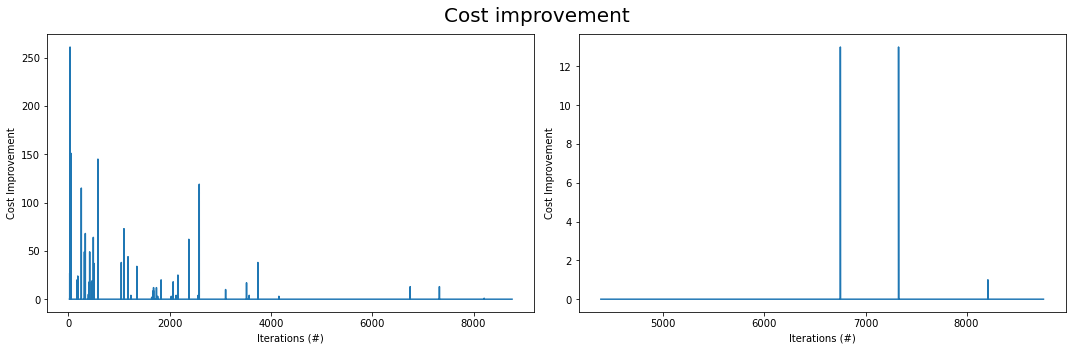

In [26]:
plot_improvements(result_mod_36, data)

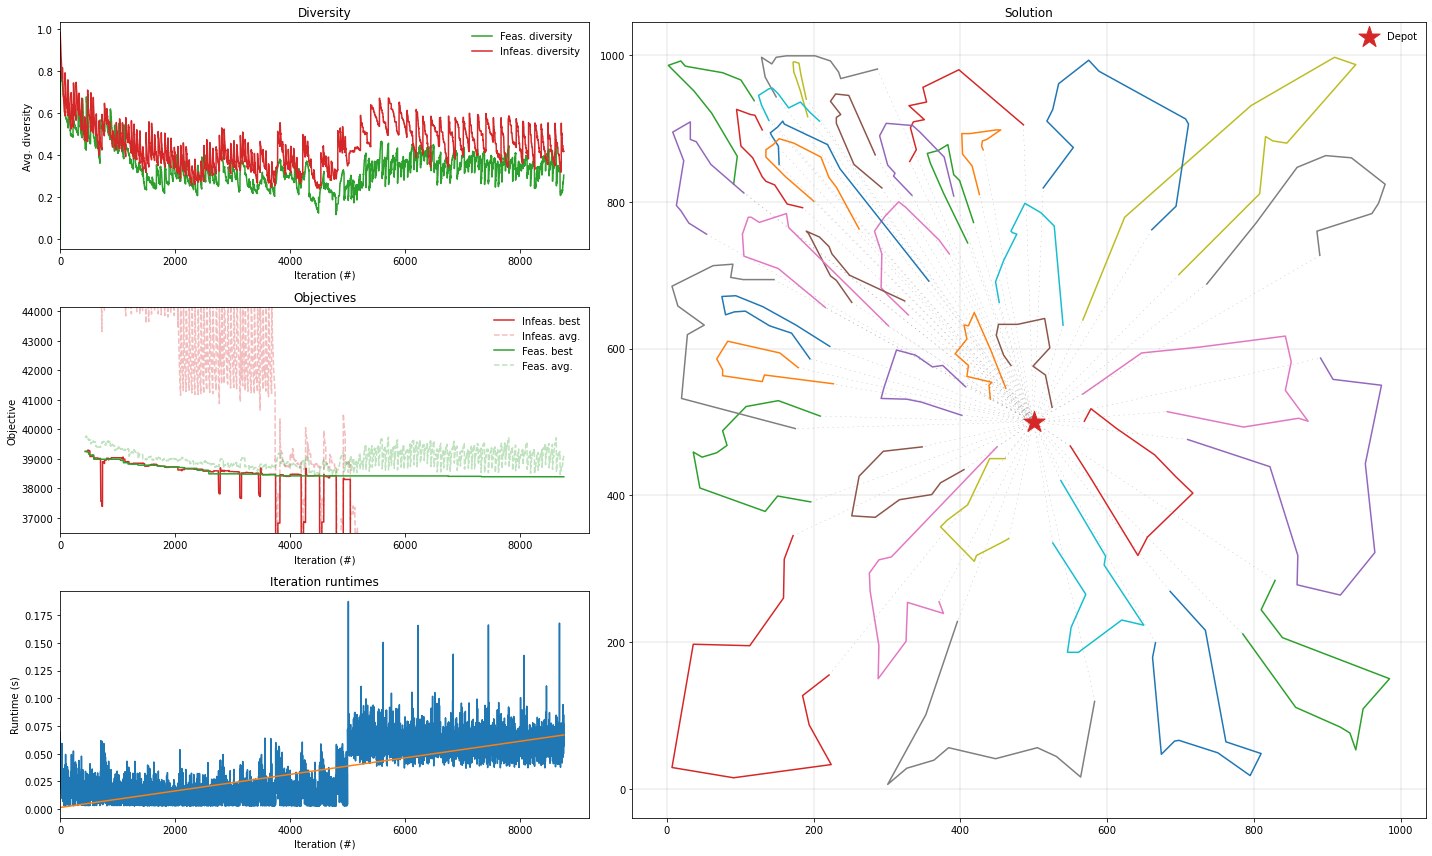

In [27]:
plot_result(result_mod_36, data)
plt.tight_layout()

In [28]:
result_36 = solve(instance_name, seed=10, max_runtime=300)

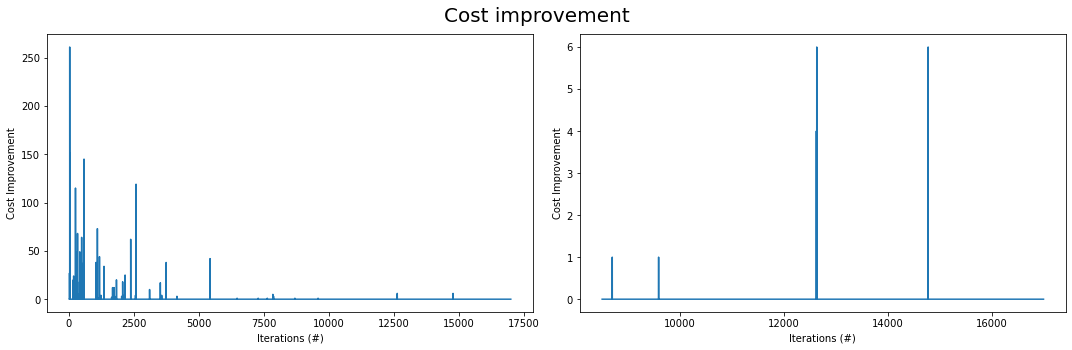

In [29]:
plot_improvements(result_36, data)

In [30]:
print(result_36)

Solution results
    # routes: 38
   # clients: 392
   objective: 38353.00
# iterations: 16991
    run-time: 300.00 seconds

Routes
------
Route #1: 311 256 254 202 131 298 197 285 381 12 271 
Route #2: 338 208 186 291 312 219 267 331 320 
Route #3: 73 49 126 71 96 164 139 146 90 330 120 125 
Route #4: 105 65 137 1 58 129 84 174 162 179 127 
Route #5: 334 305 248 203 207 234 378 332 231 213 
Route #6: 264 355 309 61 9 20 369 154 220 
Route #7: 177 2 145 68 67 104 78 29 184 4 158 
Route #8: 128 136 69 130 3 180 74 23 110 62 40 
Route #9: 244 8 169 141 19 46 152 323 349 
Route #10: 34 192 60 181 43 28 16 32 39 85 
Route #11: 22 33 196 157 53 108 98 5 42 133 187 
Route #12: 171 27 214 56 199 284 281 294 250 322 301 185 
Route #13: 119 30 64 41 99 31 112 163 161 10 
Route #14: 170 358 147 193 118 77 191 194 91 138 
Route #15: 168 75 107 106 144 173 44 11 183 166 
Route #16: 238 103 360 249 63 237 345 72 295 81 
Route #17: 59 190 15 182 35 159 189 195 111 218 
Route #18: 26 6 97 114 37 156 

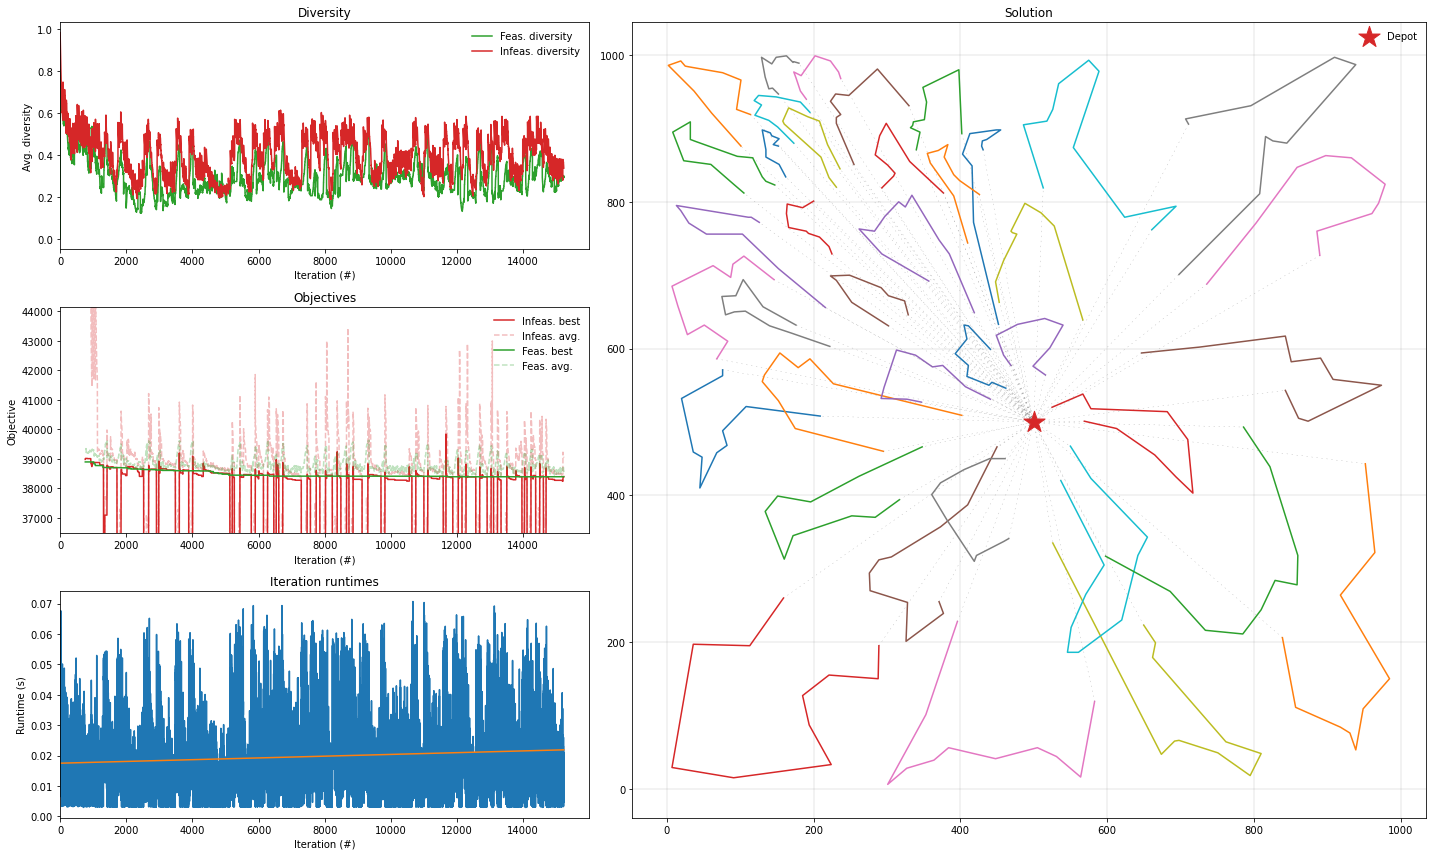

In [16]:
plot_result(result_36, data)
plt.tight_layout()